c:\Users\lmcr-\miniconda3\envs\dsi_participant\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


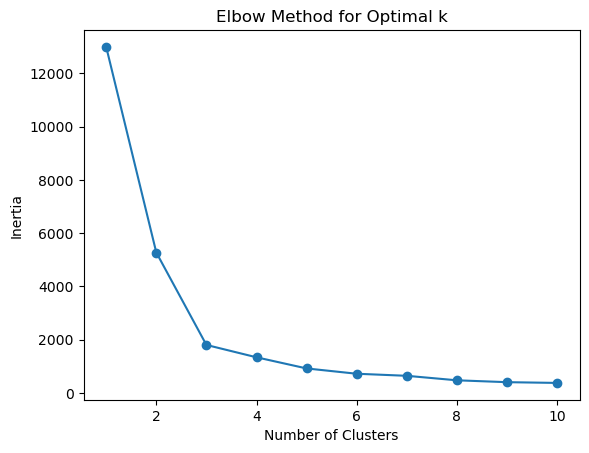

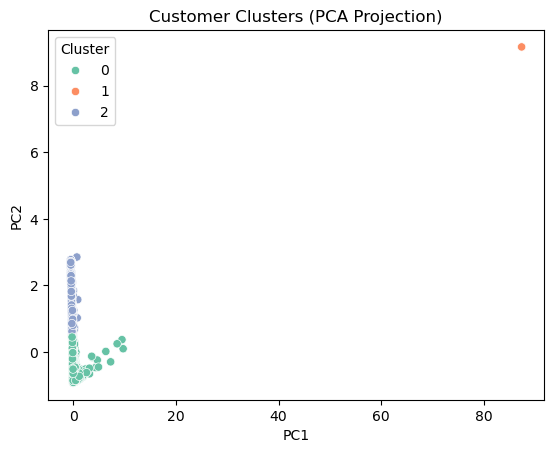

PC1 weights: [-0.11  0.7   0.7 ]
PC2 weights: [0.99 0.05 0.11]


Monetary             Frequency         AvgOrderValue         
               mean      median      mean  median          mean   median
Cluster                                                                 
0           2453.62      921.07      5.12     3.0        397.65   308.74
1        1691524.48  1691524.48   1363.00  1363.0       1241.03  1241.03
2            573.96      311.13      1.60     1.0        346.38   232.54

C:\Users\lmcr-\AppData\Local\Temp\ipykernel_12576\3863497859.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = customer_df.groupby(['Cluster', 'RecencyCategory']).agg({
C:\Users\lmcr-\AppData\Local\Temp\ipykernel_12576\3863497859.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
C:\Users\lmcr-\AppData\Local\Temp\ipykernel_12576\3863497859.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_df, x

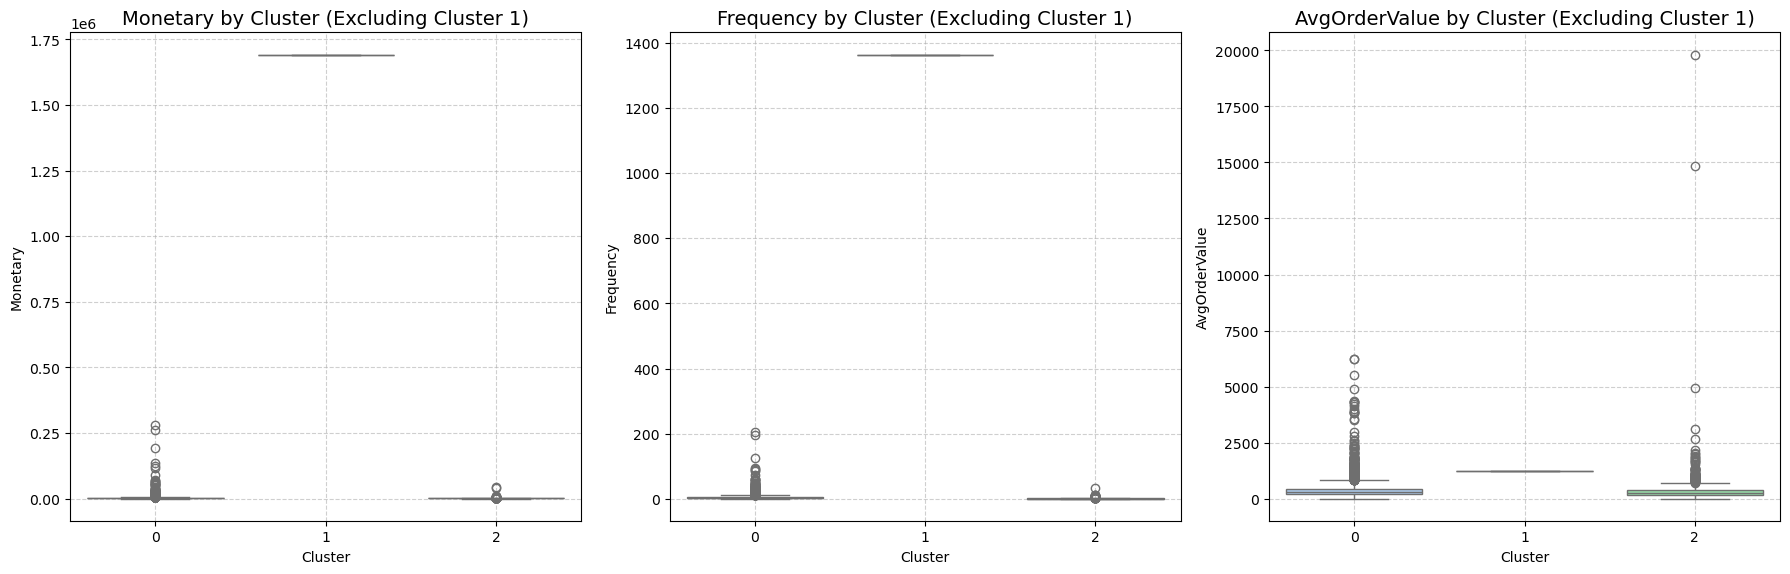

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA


# Load the cleaned dataset
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Filter out cancelled transactions
df['IsCancelled'] = df['CancellationFlag'].notnull() & (df['CancellationFlag'].astype(str).str.strip() != '')
df_clean = df[~df['IsCancelled']]

customer_df = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',       # Frequency
    'Subtotal': 'sum',            # Monetary
    'InvoiceDate': 'max'          # Last purchase date
}).rename(columns={
    'InvoiceNo': 'Frequency',
    'Subtotal': 'Monetary',
    'InvoiceDate': 'LastPurchase'
})

# Recency: days since last purchase
latest_date = df_clean['InvoiceDate'].max()
customer_df['Recency'] = (latest_date - customer_df['LastPurchase']).dt.days
customer_df.drop(columns='LastPurchase', inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[['Recency', 'Frequency', 'Monetary']])

inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    inertia.append(model.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=4)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)

customer_df['AvgOrderValue'] = customer_df['Monetary'] / customer_df['Frequency']
customer_df['RecencyCategory'] = pd.cut(customer_df['Recency'], bins=[-1, 30, 90, 180, 9999],
                                        labels=['Recent', 'Warm', 'Cool', 'Dormant'])




pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
customer_df['PC1'] = pca_components[:, 0]
customer_df['PC2'] = pca_components[:, 1]

sns.scatterplot(data=customer_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Customer Clusters (PCA Projection)')
plt.show()

pca = PCA(n_components=2)
pca.fit(scaled_features)
print("PC1 weights:", np.round(pca.components_[0], 2))
print("PC2 weights:", np.round(pca.components_[1], 2))


summary = customer_df.groupby('Cluster').agg({
    'Monetary': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'AvgOrderValue': ['mean', 'median']
}).round(2)
display(summary)


# Group by Cluster and RecencyCategory (if available)
pivot_table = customer_df.groupby(['Cluster', 'RecencyCategory']).agg({
    'Monetary': 'sum',
    'Frequency': 'mean'
}).reset_index()

pivot_table = pivot_table[pivot_table['Monetary'] > 0]

# Calculate total monetary for percentage column
total_monetary = pivot_table['Monetary'].sum()
pivot_table['MonetaryPct'] = (pivot_table['Monetary'] / total_monetary * 100).round(2)

# Rename columns for clarity
pivot_table.rename(columns={
    'Monetary': 'Sum of Monetary',
    'MonetaryPct': 'Sum of Monetary (%)',
    'Frequency': 'Average of Frequency'
}, inplace=True)

# Format and style for display
styled_pivot = pivot_table.style.set_caption("Pivot Summary: Customer Segments by Cluster and Recency") \
    .format({
        'Sum of Monetary': '{:,.2f}',
        'Sum of Monetary (%)': '{:.2f}%',
        'Average of Frequency': '{:,.2f}'
    }) 

print(styled_pivot)



# Define metrics to plot
metrics = ['Monetary', 'Frequency', 'AvgOrderValue']
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6))

# Create boxplots for each metric
for i, metric in enumerate(metrics):
    sns.boxplot(data=customer_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
    axes[i].set_title(f'{metric} by Cluster (Excluding Cluster 1)', fontsize=14)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [3]:
customer_df

,Frequency,Monetary,Recency,Cluster,AvgOrderValue,RecencyCategory,PC1,PC2
CustomerID,,,,,,,,
12347,7,4310.00,1,0,615.714286,Recent,0.231633,-0.884287
12348,4,1797.24,74,0,449.310000,Warm,-0.012840,-0.178340
12349,1,1757.55,18,0,1757.550000,Recent,-0.045917,-0.740839
12350,1,334.40,309,2,334.400000,Dormant,-0.415040,2.137011
12352,7,2385.71,35,0,340.815714,Warm,0.142924,-0.555012
...,...,...,...,...,...,...,...,...
guest_Hong Kong,8,10127.99,42,0,1265.998750,Warm,0.367666,-0.452479
guest_Israel,3,913.57,91,0,304.523333,Cool,-0.087154,-0.015873
guest_Portugal,1,307.21,44,0,307.210000,Warm,-0.113205,-0.488957


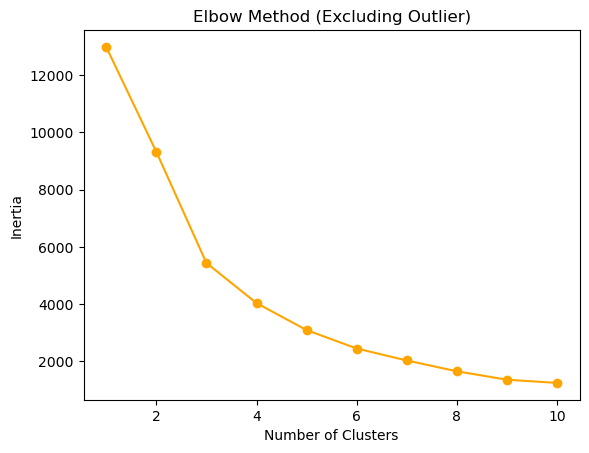

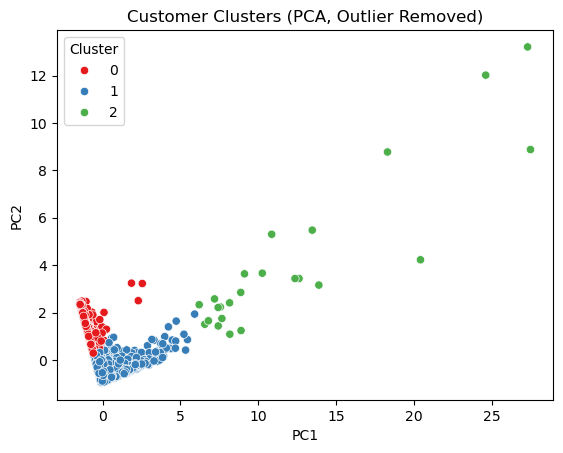

PC1 weights (filtered): [-0.37  0.67  0.64]
PC2 weights (filtered): [0.91 0.14 0.39]


Monetary           Frequency        AvgOrderValue         
             mean    median      mean median          mean   median
Cluster                                                            
0          556.43    310.47      1.57    1.0        344.72   230.35
1         1871.11    919.61      4.66    3.0        388.49   308.18
2        82425.61  59557.62     69.54   56.0       1731.74  1152.23

C:\Users\lmcr-\AppData\Local\Temp\ipykernel_12576\820445445.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_filtered = filtered_customer_df.groupby(['Cluster', 'RecencyCategory']).agg({
C:\Users\lmcr-\AppData\Local\Temp\ipykernel_12576\820445445.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_customer_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
C:\Users\lmcr-\AppData\Local\Temp\ipykernel_12576\820445445.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(dat

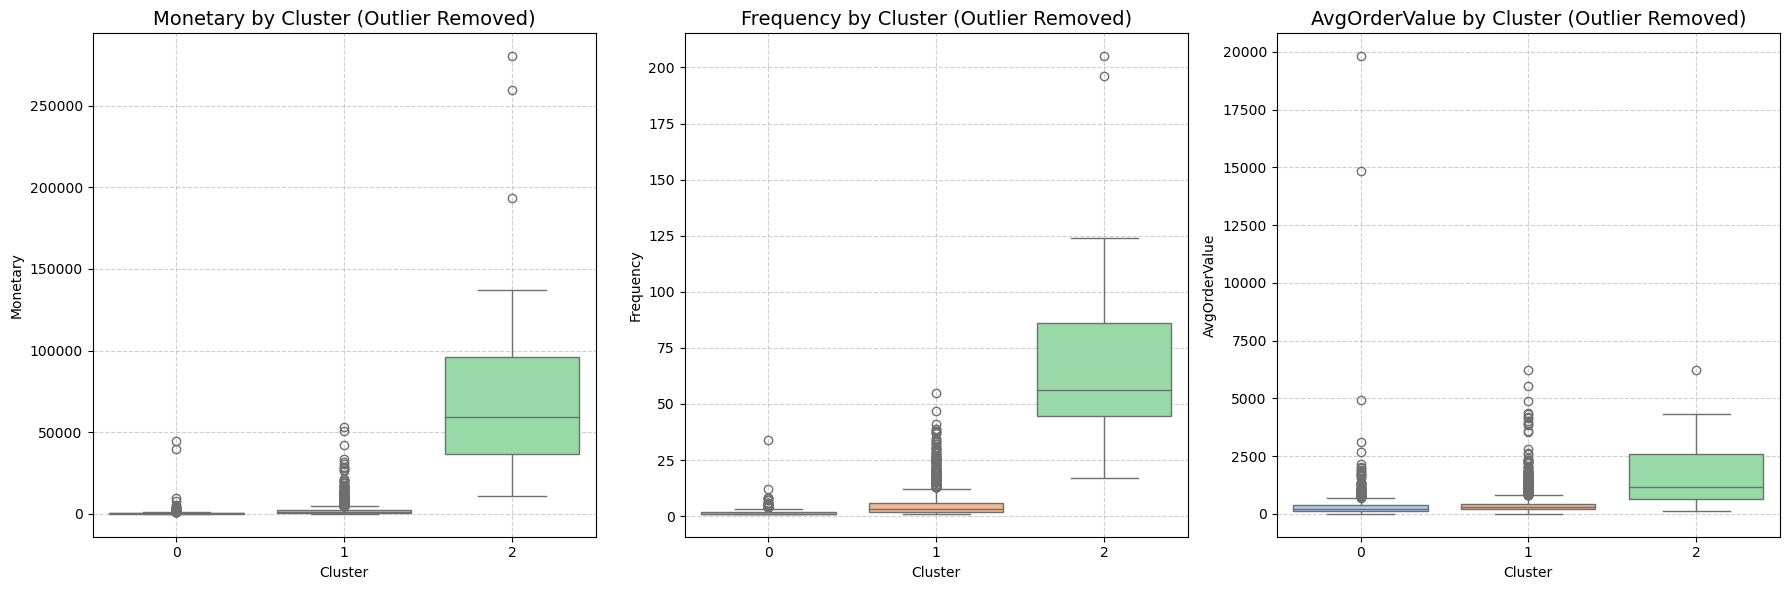

In [4]:
# --- SECOND MODEL: Exclude 'guest-United Kingdom' outlier ---
# Step 1: Filter out the outlier
filtered_customer_df = customer_df.drop(index='guest_United Kingdom', errors='ignore')
#rfm = rfm[~rfm['CustomerID'].str.strip().str.lower().eq('guest_united kingdom')]

# Step 2: Re-scale features
scaled_filtered = scaler.fit_transform(filtered_customer_df[['Recency', 'Frequency', 'Monetary']])

# Step 3: Re-run elbow method (optional but useful)
inertia_filtered = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_filtered)
    inertia_filtered.append(model.inertia_)

plt.plot(range(1, 11), inertia_filtered, marker='o', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method (Excluding Outlier)')
plt.show()

# Step 4: Fit new KMeans model
kmeans_filtered = KMeans(n_clusters=3, random_state=4)
filtered_customer_df['Cluster'] = kmeans_filtered.fit_predict(scaled_filtered)

# Step 5: Add derived features
filtered_customer_df['AvgOrderValue'] = filtered_customer_df['Monetary'] / filtered_customer_df['Frequency']
filtered_customer_df['RecencyCategory'] = pd.cut(filtered_customer_df['Recency'], bins=[-1, 30, 90, 180, 9999],
                                                  labels=['Recent', 'Warm', 'Cool', 'Dormant'])

# Step 6: PCA for visualization
pca_filtered = PCA(n_components=2)
pca_components_filtered = pca_filtered.fit_transform(scaled_filtered)
filtered_customer_df['PC1'] = pca_components_filtered[:, 0]
filtered_customer_df['PC2'] = pca_components_filtered[:, 1]

sns.scatterplot(data=filtered_customer_df, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title('Customer Clusters (PCA, Outlier Removed)')
plt.show()

# Step 7: Print PCA weights
print("PC1 weights (filtered):", np.round(pca_filtered.components_[0], 2))
print("PC2 weights (filtered):", np.round(pca_filtered.components_[1], 2))

# Step 8: Summary stats
summary_filtered = filtered_customer_df.groupby('Cluster').agg({
    'Monetary': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'AvgOrderValue': ['mean', 'median']
}).round(2)
display(summary_filtered)

# Step 9: Pivot table
pivot_filtered = filtered_customer_df.groupby(['Cluster', 'RecencyCategory']).agg({
    'Monetary': 'sum',
    'Frequency': 'mean'
}).reset_index()

pivot_filtered = pivot_filtered[pivot_filtered['Monetary'] > 0]
total_monetary_filtered = pivot_filtered['Monetary'].sum()
pivot_filtered['MonetaryPct'] = (pivot_filtered['Monetary'] / total_monetary_filtered * 100).round(2)

pivot_filtered.rename(columns={
    'Monetary': 'Sum of Monetary',
    'MonetaryPct': 'Sum of Monetary (%)',
    'Frequency': 'Average of Frequency'
}, inplace=True)

styled_pivot_filtered = pivot_filtered.style.set_caption("Pivot Summary (Outlier Removed)") \
    .format({
        'Sum of Monetary': '{:,.2f}',
        'Sum of Monetary (%)': '{:.2f}%',
        'Average of Frequency': '{:,.2f}'
    })

print(styled_pivot_filtered)

# Step 10: Boxplots
metrics = ['Monetary', 'Frequency', 'AvgOrderValue']
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6))

for i, metric in enumerate(metrics):
    sns.boxplot(data=filtered_customer_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
    axes[i].set_title(f'{metric} by Cluster (Outlier Removed)', fontsize=14)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [5]:
# --- Export Results to Excel ---
# Original clustering output
customer_df.to_excel("../data/customer_clusters_original.xlsx", index=True)

# Filtered clustering output (excluding 'guest-United Kingdom')
filtered_customer_df.to_excel("../data/customer_clusters_filtered.xlsx", index=True)

print(" Export complete: Results saved to '../data/customer_clusters_original.xlsx' and '../data/customer_clusters_filtered.xlsx'")

 Export complete: Results saved to '../data/customer_clusters_original.xlsx' and '../data/customer_clusters_filtered.xlsx'
